In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

execfile('midi_to_state.py')
daft_state = midiToNoteStateMatrix('daft_punk-one_more_time.mid')
len(daft_state)

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 2000.)


2401

In [2]:
def encode_midi_states(state_mat):
    chord_to_idx = {}
    idx_to_chord = {}
    for sixteenth_note in state_mat:
        notes_only = [note[0] for note in sixteenth_note]
        note_idcs_set = tuple([i for i, x in enumerate(notes_only) if x == 1])
        if len(note_idcs_set) == 0: note_idcs_set = (None)
        if not note_idcs_set in chord_to_idx.keys():
            new_idx = len(chord_to_idx) + 1
            chord_to_idx[note_idcs_set] = new_idx
            idx_to_chord[new_idx] = note_idcs_set
        else:
            note_set_idx = chord_to_idx[note_idcs_set]
    return [chord_to_idx, idx_to_chord]

results = encode_midi_states(daft_state)
print (len(results[0]))
print (len(results[1]))
chord_to_idx = results[0]
idx_to_chord = results[1]

381
381


In [3]:
import random
randnum = random.sample(range(len(results[0])),1)[0]
print randnum
assert(results[0][results[1][randnum]] == randnum)

249


In [5]:
# now the set of chords is a library of possible classes
# return a num_notes x len_chord_set
def encode_song(midi_states, chord_to_idx):
    song_encoded = np.zeros((len(midi_states)+1, len(chord_to_idx)+1))
    for index in range(len(midi_states)):
        notes_only = [note[0] for note in midi_states[index]]
        note_idcs_set = tuple([i for i, x in enumerate(notes_only) if x == 1])
        if len(note_idcs_set) == 0: note_idcs_set = (None)
        library_idx = chord_to_idx[note_idcs_set]
        song_encoded.itemset((index,library_idx), 1)
    return song_encoded

encoded_song = encode_song(daft_state, results[0])
len(encoded_song)

2402

In [6]:
randnum = random.sample(range(len(encoded_song)),1)[0]
print randnum
assert(sum(encoded_song[randnum]) == 1)

1393


In [7]:
chord_to_idx = results[0]
idx_to_chord = results[1]

maxlen = 40
step = 3
chunks = []
next_chords = []
for i in range(0, len(encoded_song) - maxlen, step):
    chunks.append(encoded_song[i: i + maxlen])
    next_chords.append(encoded_song[i + maxlen])

# len(chunks) should == len(daft_state)/step
assert(len(chunks) == len(next_chords))

X = np.array(chunks)
y = np.array(next_chords)
print(X.shape)
print(y.shape)
print(sum(y[0]))

(788, 40, 382)
(788, 382)
1.0


In [14]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chord_to_idx)+1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Build model...


In [16]:
hist = model.fit(X, y, batch_size=128, nb_epoch=20)
print hist.history

Epoch 1/20
788/788 [==============================] - 2s - loss: 3.4766 - acc: 0.1701     
Epoch 2/20
788/788 [==============================] - 2s - loss: 3.4101 - acc: 0.1827     
Epoch 3/20
788/788 [==============================] - 2s - loss: 3.3594 - acc: 0.1929     
Epoch 4/20
788/788 [==============================] - 2s - loss: 3.4466 - acc: 0.1802     
Epoch 5/20
788/788 [==============================] - 2s - loss: 3.3310 - acc: 0.1942     
Epoch 6/20
788/788 [==============================] - 2s - loss: 3.2562 - acc: 0.1904     
Epoch 7/20
788/788 [==============================] - 2s - loss: 3.2009 - acc: 0.2005     
Epoch 8/20
788/788 [==============================] - 2s - loss: 3.1808 - acc: 0.2145     
Epoch 9/20
788/788 [==============================] - 2s - loss: 3.1204 - acc: 0.2322     
Epoch 10/20
788/788 [==============================] - 2s - loss: 3.0794 - acc: 0.2030     
Epoch 11/20
788/788 [==============================] - 2s - loss: 3.0734 - acc: 0.2272   

In [12]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(chord_to_idx)+1))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Build model...


In [13]:
model.fit(X, y, batch_size=128, nb_epoch=20)

Epoch 1/20
788/788 [==============================] - 3s - loss: 5.5798 - acc: 0.0495     
Epoch 2/20
788/788 [==============================] - 3s - loss: 5.0820 - acc: 0.0457     
Epoch 3/20
788/788 [==============================] - 3s - loss: 4.8778 - acc: 0.0660     
Epoch 4/20
788/788 [==============================] - 3s - loss: 4.8023 - acc: 0.0571     
Epoch 5/20
788/788 [==============================] - 3s - loss: 4.7255 - acc: 0.0635     
Epoch 6/20
788/788 [==============================] - 3s - loss: 4.7584 - acc: 0.0393     
Epoch 7/20
788/788 [==============================] - 3s - loss: 4.6553 - acc: 0.0635     
Epoch 8/20
788/788 [==============================] - 3s - loss: 4.6480 - acc: 0.0673     
Epoch 9/20
788/788 [==============================] - 3s - loss: 4.6178 - acc: 0.0647     
Epoch 10/20
788/788 [==============================] - 3s - loss: 4.6676 - acc: 0.0470     
Epoch 11/20
788/788 [==============================] - 3s - loss: 4.6109 - acc: 0.0736   

In [ ]:
hidden_sizes = [10,100,200,300,500,1000]
epochs = 100
results = {}
for size in hidden_sizes:
    print('Build model...')
    model = Sequential()
    model.add(LSTM(size, return_sequences=True, input_shape=(maxlen, len(chord_to_idx)+1)))
    model.add(Dropout(0.2))
    model.add(LSTM(size, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(chord_to_idx)+1))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    hist = model.fit(X, y, batch_size=128, nb_epoch=epochs, verbose=0)
    results[size] = hist


Build model...
Build model...
Build model...
Build model...
Build model...
Build model...


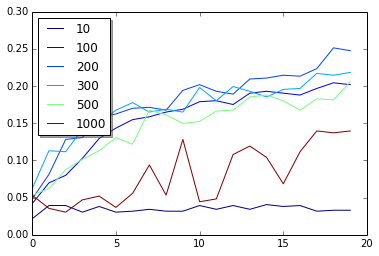

In [35]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

xran = xrange(0,epochs)
norm = colors.Normalize(min(hidden_sizes), max(hidden_sizes))

for size in hidden_sizes:
    color = cm.jet(norm(size))
    plt.plot(xran, results[size].history['acc'], 'b-', label=str(size), color = color)

legend = plt.legend(loc='upper left', shadow=True)    
plt.show()

In [ ]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = np.log(a) / temperature
    a = np.exp(a) / np.sum(np.exp(a))
    return np.argmax(np.random.multinomial(1, a, 1))

start_index = random.randint(0, len(encoded_song) - maxlen - 1)
generated = []
song_chunk = encoded_song[start_index: start_index + maxlen]
generated.append(song_chunk)
print('----- Generating with seed: "' + sentence + '"')
sys.stdout.write(generated)

for i in range(400):
    x = np.zeros((1, maxlen, len(chord_to_idx)))
    for t, char in enumerate(song_chunk):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

In [ ]:
def generated_sequence_to_midi_state(one_hot_chords):
    # takes a matrix of vectors, and uses idx_to_chords to get the chords set
    midi_states = []
    # find index of 1 in each one_hot_chord    
    for one_hot in one_hot_chords:
        note_state = np.zeros((len(daft_state[0]), 2))
        chord_set_idx = one_hot.index(1)
        notes_in_chord = idx_to_chords[chord_set_idx]
        for note in notes_in_chord:
            note_state.itemsset((note, 0), 1)
        midi_states.append(note_state)
    return midi_states
